In [9]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from datetime import datetime
from datetime import datetime, timedelta


Connect to the SQLite Database

In [10]:
# Create engine to connect to the SQLite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



In [31]:
# Reflect the database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)



C:\Users\ayafa\AppData\Local\Temp\ipykernel_8600\2966931914.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session (link) from Python to the database
session = Session(engine)

Precipitation Analysis

In [50]:
# Find the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date


('2017-08-23',)

In [15]:
# Calculate the date 12 months before the most recent date
most_recent_date_str = most_recent_date[0]
most_recent_date_dt = datetime.strptime(most_recent_date_str, "%Y-%m-%d")
one_year_ago = most_recent_date_dt - timedelta(days=365)  # Correct use of timedelta

# Convert the date to a string in the format 'YYYY-MM-DD'
one_year_ago_str = one_year_ago.strftime("%Y-%m-%d")

# Query the previous 12 months of precipitation data
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago_str)\
    .all()

# Load the query results into a Pandas DataFrame and set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values("date")
precipitation_df.head()


,date,precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


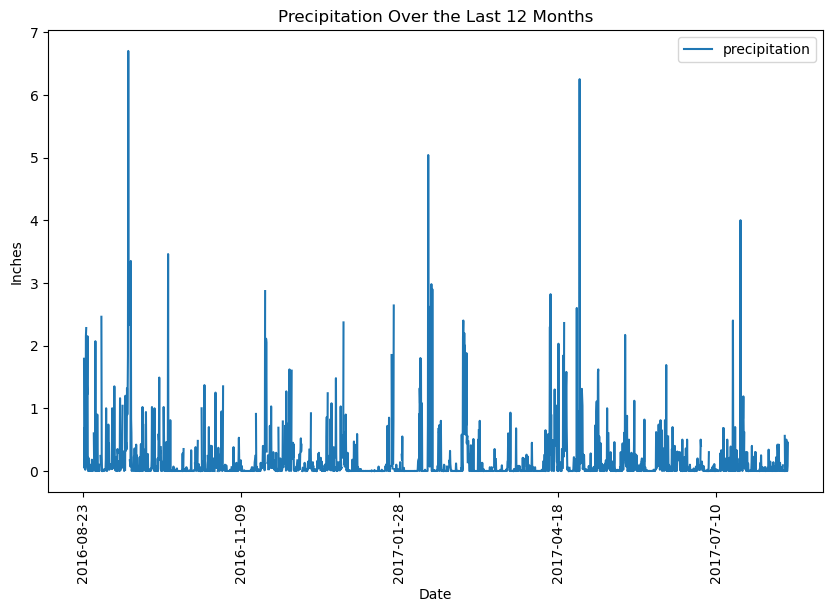

In [16]:
# Plot the precipitation data
precipitation_df.plot(x="date", y="precipitation", figsize=(10, 6), rot=90)
plt.title("Precipitation Over the Last 12 Months")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()

In [17]:
# Use Pandas to print the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Station Analysis

In [42]:
#Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).first()
total_stations


(9,)

In [44]:
#Design a query to find the most active stations (i.e., the stations with the most rows)
# List the stations and their counts in descending order
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
#Find the most active station id (the one with the most observations)
most_active_station = active_stations[0][0]
most_active_station

'USC00519281'

In [47]:
#Using the most active station id, calculate the lowest, highest, and average temperature
temperature_stats = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .all()
temperature_stats

[(54.0, 71.66378066378067, 85.0)]

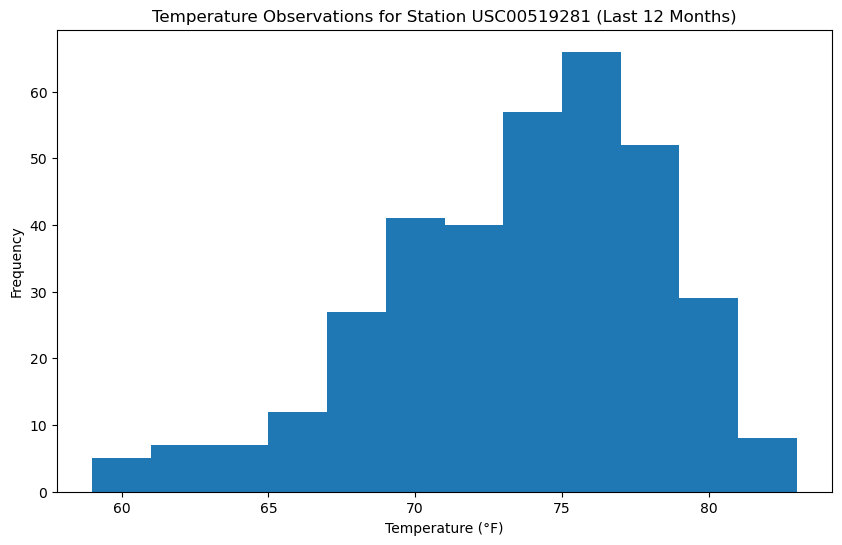

In [49]:
# Query the last 12 months of temperature observation data for this station
# Calculate the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date_dt = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date 12 months before the most recent date
one_year_ago = most_recent_date_dt - timedelta(days=365)

# Query the last 12 months of temperature observations for the most active station
tobs_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_ago)\
    .all()

# Load the TOBS data into a DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["date", "tobs"])

# Plot the results as a histogram
tobs_df['tobs'].plot.hist(bins=12, figsize=(10, 6))
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.show()

close session

In [41]:
# Close the session
session.close()
